# Stage II
## Task 1:
- ### Part 1. Compare the weekly statistics (mean, median, mode) for number of cases and deaths across US.
- ### Part 2. Compare the data against other countries of the world.
- ### Part 3. Plot daily trends (cases and deaths) of US and compare other countries. Utilize aggregrate, normalized by population, difference in cases (new cases), and log normalized values.
- ### Part 4. Identify peak week of the cases and deaths in US and other countries.

## Part 1 
- ### Compare the weekly statistics (mean, median) for number of cases and deaths across US.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [20]:
#define the utilities folder for team functions
sys.path.insert(0,"util")
import teamsuperfileutilslib as tLibs

## common defs

In [21]:
def get_totals_dataframe(dataToProcess):
    """ return a new dataframe by converting the running total to actual new total. Cleans the data of any na values.
        Adds a week number to the data from the date column. Shapes the data.
    """
    #get a grad total of the days for the confirmed cases.
    daily_cols = pd.DataFrame(dataToProcess[dataToProcess.columns[4:]].sum(axis=0)).reset_index()

    #rename column to grad total
    daily_cols.columns=["date","grand_total"]
    
    #Remove running total and get the acutal value for the day
    daily_cols.grand_total = daily_cols.grand_total.diff()

    #Fill any missing "na" values with 0
    daily_cols.grand_total = daily_cols.grand_total.fillna(value=0)

    #convert date column to a pandas date
    daily_cols["date"] = pd.to_datetime(daily_cols["date"])

    #insert a new column with the week number
    daily_cols["week_number"] = daily_cols["date"].dt.week

    #convet grand to int
    daily_cols["grand_total"] = daily_cols["grand_total"].apply(np.int64)
    
    return daily_cols

In [22]:
def create_and_shape_filter_world_dataset_for_countries(world_covid_dataset, countriesToUse = []):
    """ return a new dataframe from the world data file by the requested countries with location, date, new cases, new deaths, including per hundred for each day.
    """
    #Filter out countries we don't care about
    world_countries_set = world_covid_data[world_covid_dataset.apply(lambda x: (x["location"] in countriesToUse), axis=1)]

    #Only keep the column new cases and deaths
    world_countries_set = world_countries_set[["location", "date", "new_cases", "new_deaths", "population"]]

    #convert date column to a pandas date
    world_countries_set.date = pd.to_datetime(world_countries_set.date)
    
    #insert a new column with the week number
    world_countries_set["week_number"] = world_countries_set["date"].dt.week

    #zero out empty values
    world_countries_set["new_cases"] = world_countries_set["new_cases"].fillna(value=0)

    #zero out empty values
    world_countries_set["new_deaths"] = world_countries_set["new_deaths"].fillna(value=0)

    #convet new cases to ints
    world_countries_set["new_cases"] = world_countries_set["new_cases"].apply(np.int64)

    #convet new deaths to ints
    world_countries_set["new_deaths"] = world_countries_set["new_deaths"].apply(np.int64)

    #calculate new cases normalize by population
    world_countries_set["new_cases_norm_by_pop"] = world_countries_set.apply(lambda row: (row["new_cases"] / row["population"]) * 1000000000.00, axis=1)

    #calculate new cases normalize by population
    world_countries_set["new_deaths_norm_by_pop"] = world_countries_set.apply(lambda row: (row["new_deaths"] / row["population"]) * 1000000000.00, axis=1)
         
    #calculate new cases log normalized value
    world_countries_set["new_cases_logged"] = world_countries_set["new_cases"].apply(lambda x: 0 if x == 0 else np.log(x))

    #calculate new cases log normalized value
    world_countries_set["new_deaths_logged"]  = world_countries_set["new_deaths"].apply(lambda x: 0 if x == 0 else np.log(x))

    return world_countries_set

In [23]:
def get_country_weeks_mean_confirm_or_deaths(world_data, country, cases_or_deaths = False):
    """ return a new dataframe from the world data file by the requested country and the MEAN (rounded) for each week based on cases or deaths per hundred.
    """
    #Create new df for requested country
    country_data = world_data[world_data.apply(lambda x: (x["location"] == country), axis=1)]

    #Columns to use going forward
    cols_to_use = ["week_number", ("new_deaths_norm_by_pop","new_cases_norm_by_pop")[cases_or_deaths]]
    
    #Keep only needed colmns
    country_data = country_data[cols_to_use]

    #Group new cases or deaths for all weeks and compute mean
    country_data = country_data.groupby("week_number")[("new_deaths_norm_by_pop","new_cases_norm_by_pop")[cases_or_deaths]].agg(["mean"]).sort_values(by='week_number', ascending=True)

    #round mean to whole number
    country_data["mean"] = country_data["mean"].apply(lambda x: round(x, 0))
    
    #convet mean to int
    country_data["mean"] = country_data["mean"].apply(np.int64)

    #rename column as needed
    if cases_or_deaths == True:
        country_data.rename(columns={"mean":"cases mean"}, inplace=True)
    else:
        country_data.rename(columns={"mean": "deaths mean"}, inplace=True)
        
    return country_data

In [24]:
def print_world_country_statistics(country, world_5_confirmed, world_5_deaths):
    print(country)
    
    print("\tConfirmed Cases Mean:    {val:,.0f}".format(val=round(world_5_confirmed["cases mean"].mean())))
    print("\tConfirmed Cases Median:  {val:,.0f}".format(val=round(world_5_confirmed["cases mean"].median())))
    print("\tConfirmed Cases Mode:    {val:,.0f}".format(val=world_5_confirmed["cases mean"].mode()[0]))
    print()
    print("\tDeaths Mean:             {val:,.0f}".format(val=round(world_5_deaths["deaths mean"].mean())))
    print("\tDeaths Cases Median:     {val:,.0f}".format(val=round(world_5_deaths["deaths mean"].median())))
    print("\tDeaths Cases Mode:       {val:,.0f}".format(val=world_5_deaths["deaths mean"].mode()[0]))
    print()

In [25]:
def get_dataframe_week_value_cases_or_deaths_for_country(world_data, country,  cases_or_deaths = False):
    #columns to use for this calculation
    cols_to_use = ["week_number", ("new_deaths","new_cases")[cases_or_deaths]]
    
    #get data from world file
    data = create_and_shape_filter_world_dataset_for_countries(world_data, country)[cols_to_use]
    
    #rename columns
    data.columns=["week","totals"]
    
    #calculate the the week with the max row for need value
    data = data.groupby("week").totals.agg(["sum"])
   
    return data

In [26]:
def get_max_week_value_cases_or_deaths_for_country(world_data, country,  cases_or_deaths = False):
    #get all rows by week and the total
    data = get_dataframe_week_value_cases_or_deaths_for_country(world_data, country,  cases_or_deaths).sort_values(by='sum', ascending=False)

    #remove the index
    data.reset_index(inplace=True)
    
    #return the top week with the highest total
    return data["week"].iloc[0]

## Loading in data

In [27]:
#read team super file
team_super_df =  pd.read_csv("..\data\superCOVID-19dataframe.csv")

print(team_super_df.head())

   countyFIPS            County Name State  population  stateFIPS  \
0           0  Statewide Unallocated    AL           0          1   
1        1001         Autauga County    AL       55869          1   
2        1003         Baldwin County    AL      223234          1   
3        1005         Barbour County    AL       24686          1   
4        1007            Bibb County    AL       22394          1   

   confirmed_1/22/20  confirmed_1/23/20  confirmed_1/24/20  confirmed_1/25/20  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   confirmed_1/26/20  ...  deaths_11/10/20  deaths_11/11/20  deaths_11/12/20  \
0                 

## Calculate totals for each dataset

In [28]:
#Get confirmed cases and deaths from super team data file.
confirmed_cases, deaths = tLibs.get_confirmed_deaths_tuple_df(team_super_df)

print(confirmed_cases.head())
print(deaths.head())

   countyFIPS            County Name State  stateFIPS  1/22/20  1/23/20  \
0           0  Statewide Unallocated    AL          1        0        0   
1        1001         Autauga County    AL          1        0        0   
2        1003         Baldwin County    AL          1        0        0   
3        1005         Barbour County    AL          1        0        0   
4        1007            Bibb County    AL          1        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  11/10/20  11/11/20  11/12/20  \
0        0        0        0        0  ...         0         0         0   
1        0        0        0        0  ...      2328      2351      2385   
2        0        0        0        0  ...      7348      7409      7454   
3        0        0        0        0  ...      1107      1112      1113   
4        0        0        0        0  ...       948       961       966   

   11/13/20  11/14/20  11/15/20  11/16/20  11/17/20  11/18/20  11/19/20  
0         0       

In [29]:
#get a grad total of the days for the confirmed cases.
confirmed_daily_cols = get_totals_dataframe(confirmed_cases)

print(confirmed_daily_cols.head(5))

        date  grand_total  week_number
0 2020-01-22            0            4
1 2020-01-23            0            4
2 2020-01-24            1            4
3 2020-01-25            0            4
4 2020-01-26            3            4


In [30]:
#get a grad total of the days for the deaths.
deaths_daily_cols = get_totals_dataframe(deaths)

print(deaths_daily_cols.head(5))

        date  grand_total  week_number
0 2020-01-22            0            4
1 2020-01-23            0            4
2 2020-01-24            0            4
3 2020-01-25            0            4
4 2020-01-26            0            4


## Calculate Weeks means for each df (confirmed & deaths)

In [31]:
#Group confirmed cases by week number and calculate the mean and median.
confirm_by_week_totals = confirmed_daily_cols.groupby("week_number").grand_total.agg(["mean"]).sort_values(by='week_number', ascending=True)

#round mean to whole number
confirm_by_week_totals["mean"] = confirm_by_week_totals["mean"].apply(lambda x: round(x, 0))

#convet mean to int
confirm_by_week_totals["mean"] = confirm_by_week_totals["mean"].apply(np.int64)

#rename columns.
confirm_by_week_totals.rename(columns={"mean":"confirmed mean"}, inplace=True)

print(confirm_by_week_totals.head(5))

             confirmed mean
week_number                
4                         1
5                         1
6                         0
7                         0
8                         1


In [32]:
#Group deaths by week number and calculate the mean and median.
deaths_by_week_totals = deaths_daily_cols.groupby("week_number").grand_total.agg(["mean"]).sort_values(by='week_number', ascending=True)

#round mean to whole number
deaths_by_week_totals["mean"] = deaths_by_week_totals["mean"].apply(lambda x: round(x, 0))

#convet mean to int
deaths_by_week_totals["mean"] = deaths_by_week_totals["mean"].apply(np.int64)

#rename columns.
deaths_by_week_totals.rename(columns={"mean":"deaths mean"}, inplace=True)

print(deaths_by_week_totals.head(5))

             deaths mean
week_number             
4                      0
5                      0
6                      0
7                      0
8                      0


## Calculate mean, median, mode for all weeks for confirmed & deaths

In [33]:
#calc each statistic for confirmed cases
confirmed_cases_all_weeks_mean = round(confirm_by_week_totals["confirmed mean"].mean())
confirmed_cases_all_weeks_median = round(confirm_by_week_totals["confirmed mean"].median())
confirmed_cases_all_weeks_mode = confirm_by_week_totals["confirmed mean"].mode()

In [34]:
#calc each statistic deaths
deaths_all_weeks_mean = round(deaths_by_week_totals["deaths mean"].mean())
deaths_all_weeks_median = round(deaths_by_week_totals["deaths mean"].median())
deaths_all_weeks_mode = deaths_by_week_totals["deaths mean"].mode()

## Compare the weekly statistics (mean, median, mode) for number of cases and deaths across US for all weeks taken together.

In [35]:
# print each statistic - Confirmed Cases
print("Confirmed Cases Mean: {ccmean:,.0f}".format(ccmean=confirmed_cases_all_weeks_mean))
print("Confirmed Cases Median: {ccmedian:,.0f}".format(ccmedian=confirmed_cases_all_weeks_median))
print("Confirmed Cases Mode: {ccmode}".format(ccmode=confirmed_cases_all_weeks_mode[0]))

# print each statistic - Deaths
print("Deaths Mean: {ccmean:,.0f}".format(ccmean=deaths_all_weeks_mean))
print("Deaths Median: {ccmedian:,.0f}".format(ccmedian=deaths_all_weeks_median))
print("Deaths Mode: {ccmode}".format(ccmode=deaths_all_weeks_mode[0]))

Confirmed Cases Mean: 38,933
Confirmed Cases Median: 32,540
Confirmed Cases Mode: 1
Deaths Mean: 821
Deaths Median: 792
Deaths Mode: 0


# End of Part 1

# Part 2
- ### Compare the data against other countries of the world

## Load World Covid Data

In [36]:
#read world csv file
world_covid_data = pd.read_csv("..\data\owid-covid-data.csv")

print(world_covid_data.shape)
print(world_covid_data.head(5))

(56325, 50)
  iso_code      continent location       date  total_cases  new_cases  \
0      ABW  North America    Aruba  3/13/2020          2.0        2.0   
1      ABW  North America    Aruba  3/19/2020          NaN        NaN   
2      ABW  North America    Aruba  3/20/2020          4.0        2.0   
3      ABW  North America    Aruba  3/21/2020          NaN        NaN   
4      ABW  North America    Aruba  3/22/2020          NaN        NaN   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         0.0                  NaN  ...   
1               0.286           NaN         NaN                  0.0  ...   
2               0.286           NaN         0.0                  0.0  ...   
3               0.286           NaN         NaN                  0.0  ...   
4               0.286           NaN         NaN                  0.0  ...   

   gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
0       35973.781        

## Show list of countries with similar popluations

In [37]:
#stop printing sci notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Create empty dataframe
population_based_on_world_data = pd.DataFrame()

#fill the new dataframe with location(country name) & population
population_based_on_world_data = world_covid_data[["location", "population"]].copy()

#keep only unique rows and sort data by population deascending
population_based_on_world_data = population_based_on_world_data.drop_duplicates(subset = ["location"]).sort_values(by='population', ascending=False)

print(population_based_on_world_data.head(20))

                           location     population
55689                         World 7794798729.000
9612                          China 1439323774.000
24006                         India 1380004385.000
52371                 United States  331002647.000
23451                     Indonesia  273523621.000
39947                      Pakistan  220892331.000
7203                         Brazil  212559409.000
37800                       Nigeria  206139587.000
4859                     Bangladesh  164689383.000
43448                        Russia  145934460.000
33472                        Mexico  128932753.000
26966                         Japan  126476458.000
16581                      Ethiopia  114963583.000
40773                   Philippines  109581085.000
15190                         Egypt  102334403.000
54125                       Vietnam   97338583.000
10421  Democratic Republic of Congo   89561404.000
50840                        Turkey   84339067.000
24642                          

In [38]:
#list of countries that we are going to compare
#Brazil = South America 
#Japan  = in Asia
#Mexico = North America
#Nigera = Africa
#Russia = Europe
#These countries were chosen as a way to repersent each of the world land area & similar popluations
contries_to_compare = ['Brazil', 'Japan', 'Mexico', 'Nigeria', 'Russia']

### Shape and Filter World File for new cases and new deaths

In [39]:
#Filter out countries we don't care about
world_5_set = create_and_shape_filter_world_dataset_for_countries(world_covid_data, contries_to_compare)
print(world_5_set.head(10))

     location       date  new_cases  new_deaths    population  week_number  \
7203   Brazil 2019-12-31          0           0 212559409.000            1   
7204   Brazil 2020-01-01          0           0 212559409.000            1   
7205   Brazil 2020-01-02          0           0 212559409.000            1   
7206   Brazil 2020-01-03          0           0 212559409.000            1   
7207   Brazil 2020-01-04          0           0 212559409.000            1   
7208   Brazil 2020-01-05          0           0 212559409.000            1   
7209   Brazil 2020-01-06          0           0 212559409.000            2   
7210   Brazil 2020-01-07          0           0 212559409.000            2   
7211   Brazil 2020-01-08          0           0 212559409.000            2   
7212   Brazil 2020-01-09          0           0 212559409.000            2   

      new_cases_norm_by_pop  new_deaths_norm_by_pop  new_cases_logged  \
7203                  0.000                   0.000             0.00

### Calculate countries stats

In [40]:
#Get the new cases for each selected country
world_5_confirmed_brazil = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Brazil", cases_or_deaths=True)
world_5_confirmed_japan = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Japan", cases_or_deaths=True)
world_5_confirmed_mexico = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Mexico", cases_or_deaths=True)
world_5_confirmed_nigeria = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Nigeria", cases_or_deaths=True)
world_5_confirmed_russia = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Russia", cases_or_deaths=True)

#Get the new deaths for each selected country
world_5_deaths_brazil = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Brazil", cases_or_deaths=False)
world_5_deaths_japan = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Japan", cases_or_deaths=False)
world_5_deaths_mexico = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Mexico", cases_or_deaths=False)
world_5_deaths_nigeria = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Nigeria", cases_or_deaths=False)
world_5_deaths_russia = get_country_weeks_mean_confirm_or_deaths(world_5_set, "Russia", cases_or_deaths=False)

### Display chosen Countries statistics

In [41]:
# print each statistic - Confirmed Cases
print("*Normalized by population")
print_world_country_statistics("Brazil", world_5_confirmed_brazil, world_5_deaths_brazil)
print_world_country_statistics("Japan", world_5_confirmed_japan, world_5_deaths_japan)
print_world_country_statistics("Mexico", world_5_confirmed_mexico, world_5_deaths_mexico)
print_world_country_statistics("Nigeria", world_5_confirmed_nigeria, world_5_deaths_nigeria)
print_world_country_statistics("Russia", world_5_confirmed_russia, world_5_deaths_russia)

*Normalized by population
Brazil
	Confirmed Cases Mean:    83,846
	Confirmed Cases Median:  97,616
	Confirmed Cases Mode:    0

	Deaths Mean:             2,393
	Deaths Cases Median:     2,472
	Deaths Cases Mode:       0

Japan
	Confirmed Cases Mean:    2,828
	Confirmed Cases Median:  1,827
	Confirmed Cases Mode:    0

	Deaths Mean:             46
	Deaths Cases Median:     31
	Deaths Cases Mode:       0

Mexico
	Confirmed Cases Mean:    24,192
	Confirmed Cases Median:  30,282
	Confirmed Cases Mode:    0

	Deaths Mean:             2,352
	Deaths Cases Median:     2,902
	Deaths Cases Mode:       0

Nigeria
	Confirmed Cases Mean:    980
	Confirmed Cases Median:  742
	Confirmed Cases Mode:    0

	Deaths Mean:             18
	Deaths Cases Median:     10
	Deaths Cases Mode:       0

Russia
	Confirmed Cases Mean:    40,419
	Confirmed Cases Median:  37,452
	Confirmed Cases Mode:    0

	Deaths Mean:             694
	Deaths Cases Median:     714
	Deaths Cases Mode:       0



# End of Part 2

# Part 3
- ###  Plot daily trends (cases and deaths) of US and compare other countries. Utilize aggregrate, normalized by population, difference in cases (new cases), and log normalized values.

### Create ploting dataframes

In [42]:
#Columns need to ploting per hundred & log norm
cols_to_use_confirmed_deaths_hd = ["date", "new_cases_norm_by_pop", "new_deaths_norm_by_pop"]
cols_to_use_confirmed_deaths_log = ["date", "new_cases_logged", "new_deaths_logged"]

#Create dataframe for USA confirmed cases & deaths.
world_USA_confirmed_deaths_per_hundred = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "United States")[cols_to_use_confirmed_deaths_hd]).set_index("date")
world_USA_confirmed_deaths_log = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "United States")[cols_to_use_confirmed_deaths_log]).set_index("date")
#Rename needed columns
world_USA_confirmed_deaths_per_hundred.rename(columns={"new_cases_norm_by_pop":"Confirmed Cases", "new_deaths_norm_by_pop":"Deaths"}, inplace=True)
world_USA_confirmed_deaths_log.rename(columns={"new_cases_logged":"Confirmed Cases", "new_deaths_logged":"Deaths"}, inplace=True)

#Create dataframe for Japan confirmed cases & deaths.
world_Brazil_confirmed_deaths_per_hundred = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Brazil")[cols_to_use_confirmed_deaths_hd]).set_index("date")
world_Brazil_confirmed_deaths_log = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Brazil")[cols_to_use_confirmed_deaths_log]).set_index("date")
#Rename needed columns
world_Brazil_confirmed_deaths_per_hundred.rename(columns={"new_cases_norm_by_pop":"Confirmed Cases", "new_deaths_norm_by_pop":"Deaths"}, inplace=True)
world_Brazil_confirmed_deaths_log.rename(columns={"new_cases_logged":"Confirmed Cases", "new_deaths_logged":"Deaths"}, inplace=True)

#Create dataframe for Japan confirmed cases & deaths.
world_Japan_confirmed_deaths_per_hundred = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Japan")[cols_to_use_confirmed_deaths_hd]).set_index("date")
world_Japan_confirmed_deaths_log = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Japan")[cols_to_use_confirmed_deaths_log]).set_index("date")
#Rename needed columns
world_Japan_confirmed_deaths_per_hundred.rename(columns={"new_cases_norm_by_pop":"Confirmed Cases", "new_deaths_norm_by_pop":"Deaths"}, inplace=True)
world_Japan_confirmed_deaths_log.rename(columns={"new_cases_logged":"Confirmed Cases", "new_deaths_logged":"Deaths"}, inplace=True)

#Create dataframe for Mexico confirmed cases & deaths.
world_Mexico_confirmed_deaths_per_hundred = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Mexico")[cols_to_use_confirmed_deaths_hd]).set_index("date")
world_Mexico_confirmed_deaths_log = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Mexico")[cols_to_use_confirmed_deaths_log]).set_index("date")
#Rename needed columns
world_Mexico_confirmed_deaths_per_hundred.rename(columns={"new_cases_norm_by_pop":"Confirmed Cases", "new_deaths_norm_by_pop":"Deaths"}, inplace=True)
world_Mexico_confirmed_deaths_log.rename(columns={"new_cases_logged":"Confirmed Cases", "new_deaths_logged":"Deaths"}, inplace=True)

#Create dataframe for Nigeria confirmed cases & deaths.
world_Nigeria_confirmed_deaths_per_hundred = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Nigeria")[cols_to_use_confirmed_deaths_hd]).set_index("date")
world_Nigeria_confirmed_deaths_log = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Nigeria")[cols_to_use_confirmed_deaths_log]).set_index("date")
#Rename needed columns
world_Nigeria_confirmed_deaths_per_hundred.rename(columns={"new_cases_norm_by_pop":"Confirmed Cases", "new_deaths_norm_by_pop":"Deaths"}, inplace=True)
world_Nigeria_confirmed_deaths_log.rename(columns={"new_cases_logged":"Confirmed Cases", "new_deaths_logged":"Deaths"}, inplace=True)

#Create dataframe for Russia confirmed cases & deaths.
world_Russia_confirmed_deaths_per_hundred = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Russia")[cols_to_use_confirmed_deaths_hd]).set_index("date")
world_Russia_confirmed_deaths_log = (create_and_shape_filter_world_dataset_for_countries(world_covid_data, "Russia")[cols_to_use_confirmed_deaths_log]).set_index("date")
#Rename needed columns
world_Russia_confirmed_deaths_per_hundred.rename(columns={"new_cases_per_hundred":"Confirmed Cases", "new_deaths_norm_by_pop":"Deaths"}, inplace=True)
world_Russia_confirmed_deaths_log.rename(columns={"new_cases_logged":"Confirmed Cases", "new_deaths_logged":"Deaths"}, inplace=True)

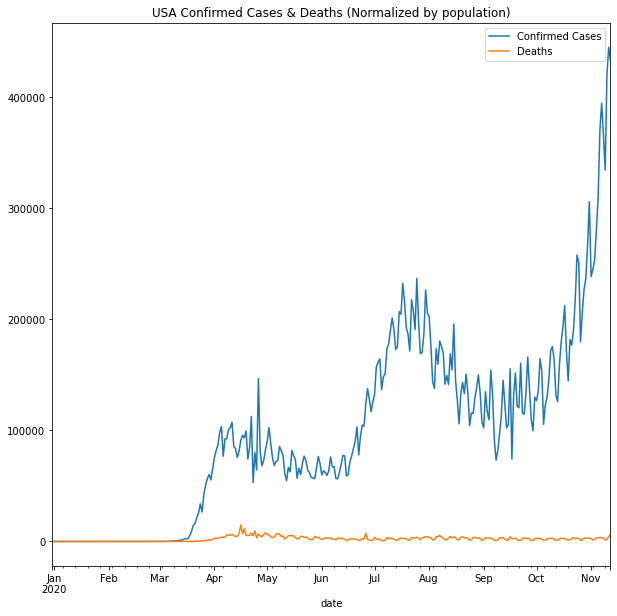

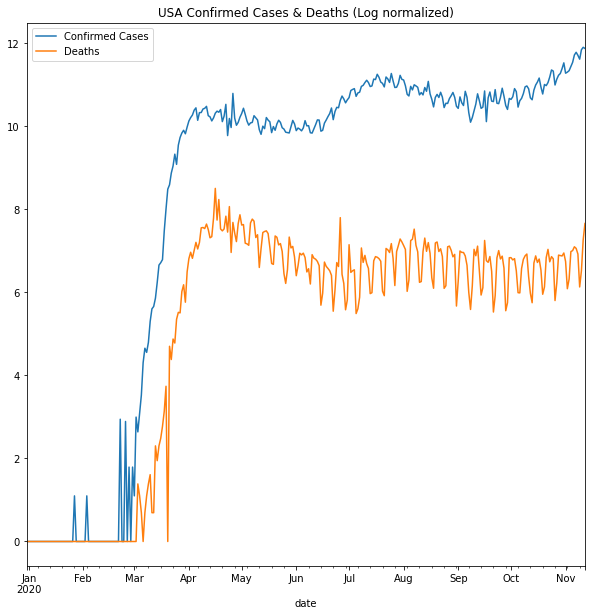

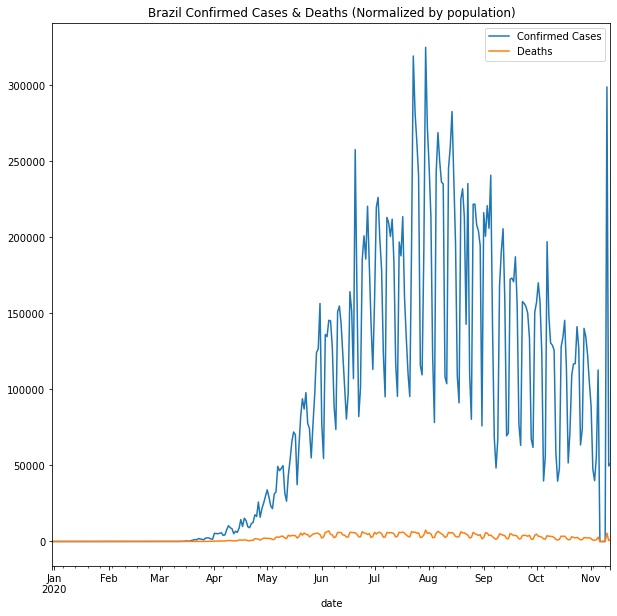

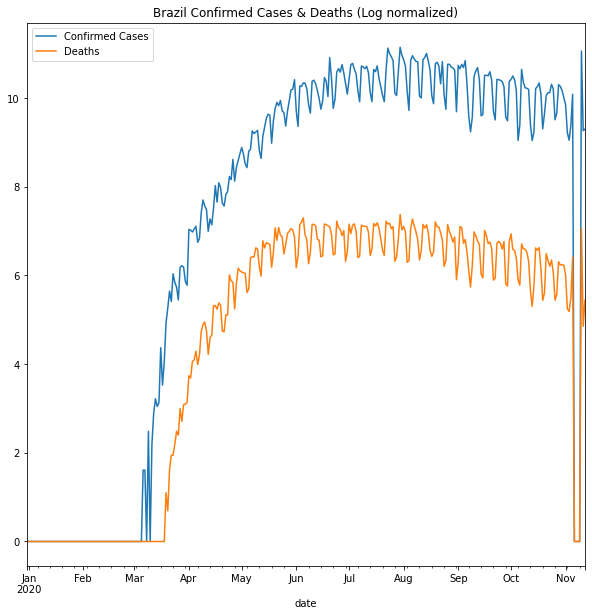

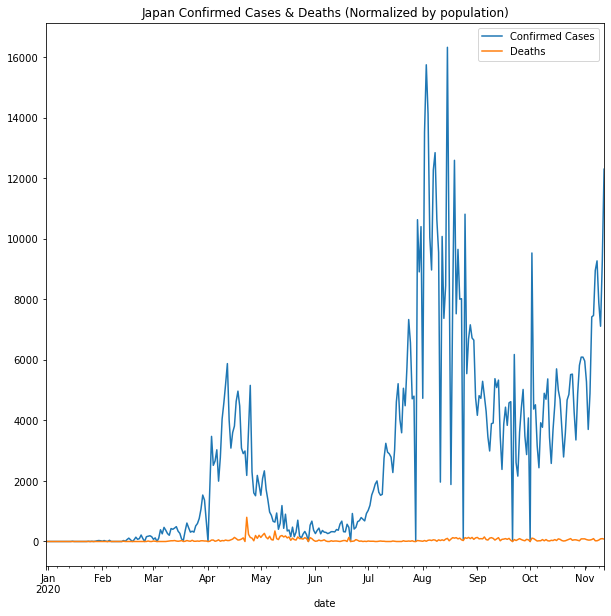

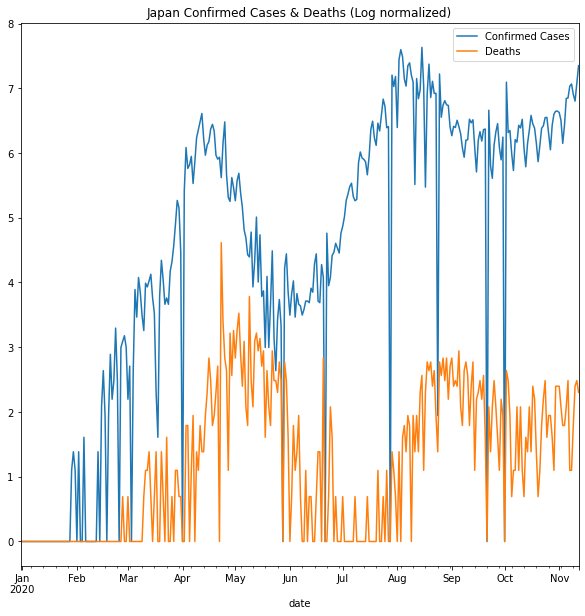

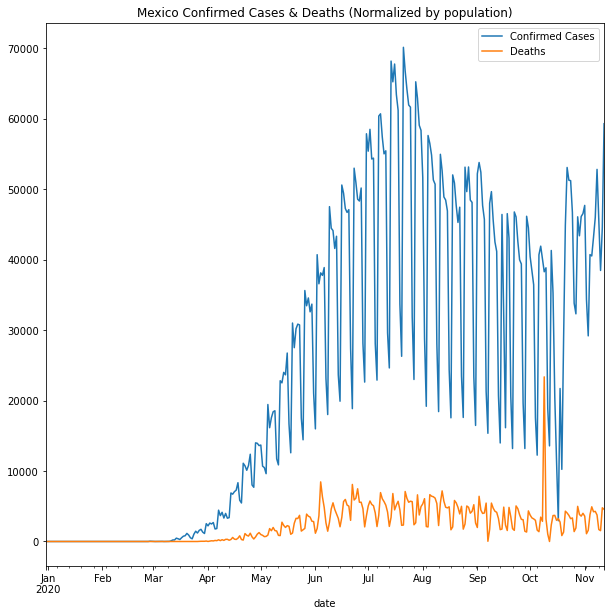

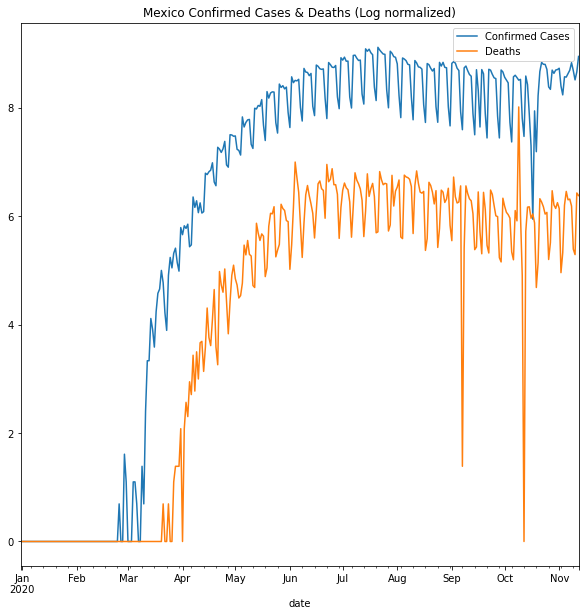

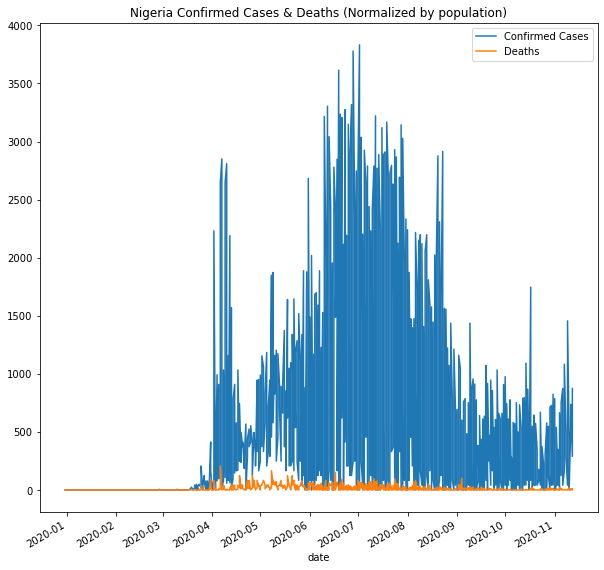

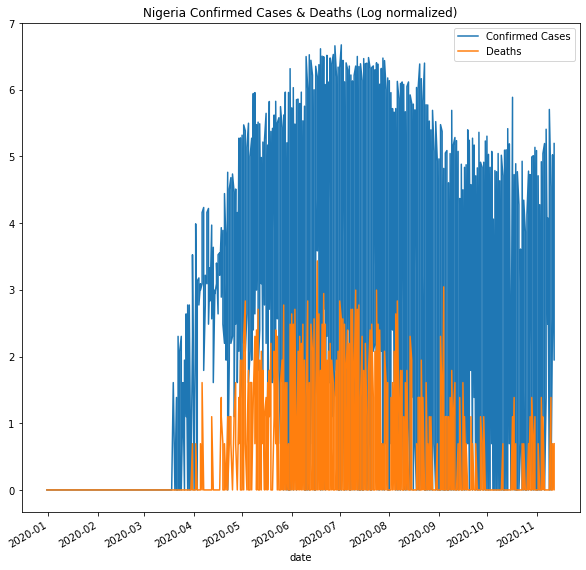

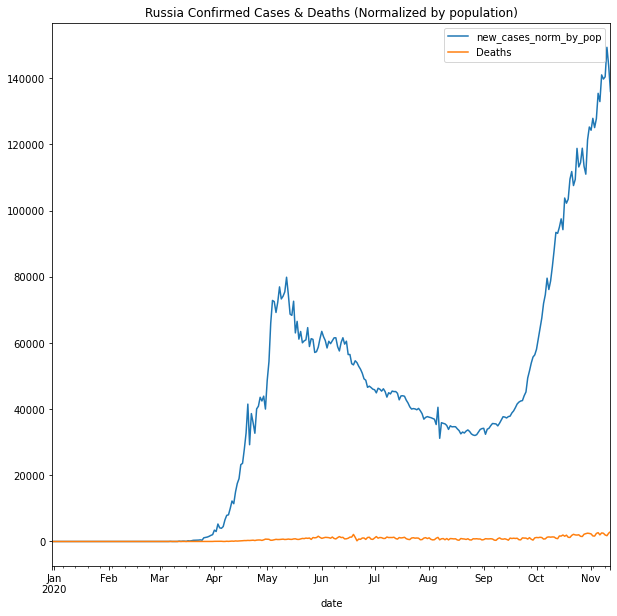

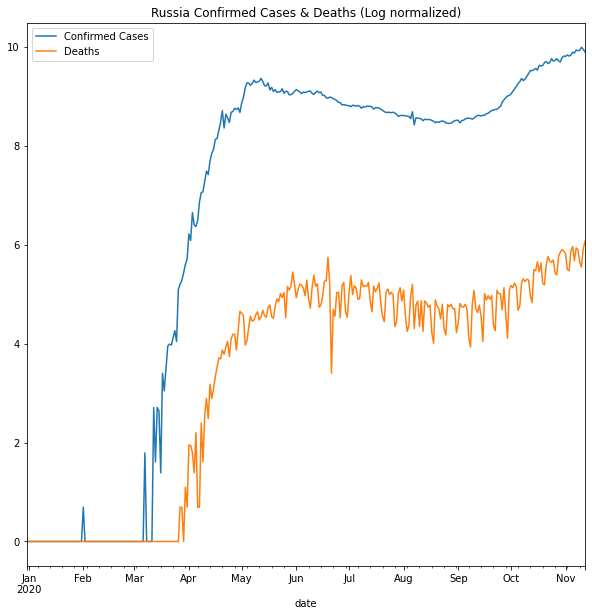

In [43]:
world_USA_confirmed_deaths_per_hundred.plot(kind="line",title="USA Confirmed Cases & Deaths (Normalized by population)", figsize=(10,10))
world_USA_confirmed_deaths_log.plot(kind="line",title="USA Confirmed Cases & Deaths (Log normalized)", figsize=(10,10))

world_Brazil_confirmed_deaths_per_hundred.plot(kind="line",title="Brazil Confirmed Cases & Deaths (Normalized by population)", figsize=(10,10))
world_Brazil_confirmed_deaths_log.plot(kind="line",title="Brazil Confirmed Cases & Deaths (Log normalized)", figsize=(10,10))

world_Japan_confirmed_deaths_per_hundred.plot(kind="line",title="Japan Confirmed Cases & Deaths (Normalized by population)", figsize=(10,10))
world_Japan_confirmed_deaths_log.plot(kind="line",title="Japan Confirmed Cases & Deaths (Log normalized)", figsize=(10,10))

world_Mexico_confirmed_deaths_per_hundred.plot(kind="line",title="Mexico Confirmed Cases & Deaths (Normalized by population)", figsize=(10,10))
world_Mexico_confirmed_deaths_log.plot(kind="line",title="Mexico Confirmed Cases & Deaths (Log normalized)", figsize=(10,10))

world_Nigeria_confirmed_deaths_per_hundred.plot(kind="line",title="Nigeria Confirmed Cases & Deaths (Normalized by population)", figsize=(10,10))
world_Nigeria_confirmed_deaths_log.plot(kind="line",title="Nigeria Confirmed Cases & Deaths (Log normalized)", figsize=(10,10))

world_Russia_confirmed_deaths_per_hundred.plot(kind="line",title="Russia Confirmed Cases & Deaths (Normalized by population)", figsize=(10,10))
world_Russia_confirmed_deaths_log.plot(kind="line",title="Russia Confirmed Cases & Deaths (Log normalized)", figsize=(10,10))

# Part 4
- ### Identify peak week of the confirmed cases and deaths in US and other countries.

In [44]:
#Calcluate week with the max new cases for each country
USA_peak_week_cases = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "United States", cases_or_deaths=True)
Brazil_peak_week_cases = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Brazil", cases_or_deaths=True)
Japan_peak_week_cases = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Japan", cases_or_deaths=True)
Mexico_peak_week_cases = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Mexico", cases_or_deaths=True)
Nigeria_peak_week_cases = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Nigeria", cases_or_deaths=True)
Russia_peak_week_cases = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Russia", cases_or_deaths=True)


In [45]:
#Calcluate week with the max new deaths for each country
USA_peak_week_deaths = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "United States", cases_or_deaths=False)
Brazil_peak_week_deaths = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Brazil", cases_or_deaths=False)
Japan_peak_week_deaths = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Japan", cases_or_deaths=False)
Mexico_peak_week_deaths = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Mexico", cases_or_deaths=False)
Nigeria_peak_week_deaths = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Nigeria", cases_or_deaths=False)
Russia_peak_week_deaths = get_max_week_value_cases_or_deaths_for_country(world_covid_data, "Russia", cases_or_deaths=False)

In [46]:
print("USA     - Peak Week - New Cases:{nc}  | New Deaths:  {nd}".format(nc=USA_peak_week_cases,nd=USA_peak_week_deaths))
print("Brazil  - Peak Week - New Cases:{nc}  | New Deaths:  {nd}".format(nc=Brazil_peak_week_cases,nd=Brazil_peak_week_deaths))
print("Japan   - Peak Week - New Cases:{nc}  | New Deaths:  {nd}".format(nc=Japan_peak_week_cases,nd=Japan_peak_week_deaths))
print("Mexico  - Peak Week - New Cases:{nc}  | New Deaths:  {nd}".format(nc=Mexico_peak_week_cases,nd=Mexico_peak_week_deaths))
print("Nigeria - Peak Week - New Cases:{nc}  | New Deaths:  {nd}".format(nc=Nigeria_peak_week_cases,nd=Nigeria_peak_week_deaths))
print("Russia  - Peak Week - New Cases:{nc}  | New Deaths:  {nd}".format(nc=Russia_peak_week_cases,nd=Russia_peak_week_deaths))

USA     - Peak Week - New Cases:45  | New Deaths:  16
Brazil  - Peak Week - New Cases:30  | New Deaths:  30
Japan   - Peak Week - New Cases:32  | New Deaths:  17
Mexico  - Peak Week - New Cases:29  | New Deaths:  26
Nigeria - Peak Week - New Cases:26  | New Deaths:  25
Russia  - Peak Week - New Cases:45  | New Deaths:  45


# End of Part 4